In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
from import_casa import casa
from casa import caprice
from icecream import ic

/Users/seantyh/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
with open("../../../data/caprice/caprice_seq_data_20210430.pkl", "rb") as fin:
    data = pickle.load(fin)

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_path = "../../../data/caprice/seq-model-ep9"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [5]:
from matplotlib import font_manager

In [6]:
import matplotlib.pyplot as plt
# plt.rcParams["font.family"] = "Microsoft JhengHei"
plt.rcParams["font.family"] = "Heiti TC"

In [7]:
import shap

In [8]:
from transformers import pipeline
caprice_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, return_all_scores=False)

In [9]:
explainer = shap.Explainer(caprice_pipeline, algorithm="partition")

In [10]:
_masker = explainer.masker

In [11]:
import torch
from DistilTag import DistilTag
tagger = DistilTag()

In [12]:
tagger.tag("我才不要去辦吃到飽")

[[('我', 'Nh'),
  ('才', 'Da'),
  ('不要', 'D'),
  ('去', 'D'),
  ('辦', 'VC'),
  ('吃', 'VC'),
  ('到', 'P'),
  ('飽', 'VH')]]

## Try hierarchical shapley

In [13]:
from types import MethodType
from functools import partial
from scipy.cluster.hierarchy import to_tree, dendrogram
txt = "他貴到一個爆炸"

clustering_wrapper = partial(caprice.custom_clustering, pat="(到一個)", tagger_inst=tagger)
explainer.masker.clustering = MethodType(clustering_wrapper, explainer.masker)
shap_values = explainer([txt], fixed_context=0)

In [15]:
# probs = [x["score"] for x in caprice_pipeline(txt)[0]]
# max_label = np.argmax(probs)
max_label = 1

In [16]:
Z = shap_values.clustering[0]

In [17]:
root, clust_nodes = to_tree(Z, rd=True)

In [18]:
Z

array([[ 5.        ,  4.        ,  0.1232772 ,  2.        ],
       [ 9.        ,  3.        ,  0.1359199 ,  3.        ],
       [ 7.        ,  6.        ,  0.17089023,  2.        ],
       [10.        ,  2.        ,  0.32278648,  4.        ],
       [11.        , 12.        ,  0.63041645,  6.        ],
       [ 1.        ,  0.        ,  0.64684439,  2.        ],
       [13.        , 14.        ,  0.75969929,  8.        ],
       [ 8.        , 15.        ,  1.        ,  9.        ]])

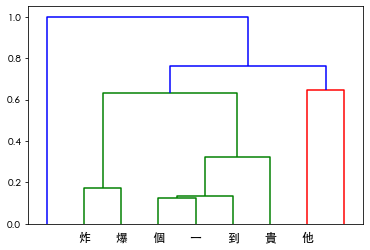

In [19]:
ex_tokens = _masker._segments_s
dendrogram(shap_values.clustering[0], labels=ex_tokens);

In [20]:
# check dimensions
ic(Z.shape, len(ex_tokens))
ic(len(clust_nodes), shap_values.hierarchical_values[0].shape)

ic| Z.shape: (8, 4), len(ex_tokens): 9
ic| len(clust_nodes): 17
    shap_values.hierarchical_values[0].shape: (17, 3)


(17, (17, 3))

In [21]:
proc_vals = caprice.process_shap_values(shap_values[0, :, max_label])

In [22]:
proc_vals

{'tokens': array(['', '炸', '爆', '個一到貴', '他', ''], dtype='<U4'),
 'values': array([ 1.51804577e-07,  3.42333236e-02,  3.42333236e-02,  1.02977670e+00,
        -4.75178627e-02, -4.75178627e-02]),
 'group_sizes': array([1, 1, 1, 4, 1, 1]),
 'upper_values': array([-4.75178627e-02, -4.75178627e-02,  5.14888350e-01,  2.57444175e-01,
         1.28722087e-01,  1.28722087e-01,  3.42333236e-02,  3.42333236e-02,
         1.51804577e-07,  2.57444175e-01,  5.14888350e-01,  6.84666473e-02,
         6.84666473e-02, -9.50357253e-02, -9.50357253e-02,  1.51804577e-07,
         0.00000000e+00]),
 'lower_values': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.96131005, 1.19327907, 0.        ,
        1.00320747, 1.00320777]),
 'group_values': array([-4.75178627e-02, -4.75178627e-02,  5.14888350e-01,  2.57444175e-01,
         1.28722087e-01,  1.28722087e-01,  3.42333236e-02,  3.42333236

In [23]:
group_values = proc_vals["group_values"]
for node_i, node_x in enumerate(clust_nodes):
    leaf_ids = node_x.pre_order(lambda x: x.id)
    print("% .2e" % group_values[node_i], "".join(ex_tokens[x] for x in sorted(leaf_ids)))

-4.75e-02 
-4.75e-02 他
 5.15e-01 貴
 2.57e-01 到
 1.29e-01 一
 1.29e-01 個
 3.42e-02 爆
 3.42e-02 炸
 1.52e-07 
 2.57e-01 一個
 5.15e-01 到一個
 6.85e-02 爆炸
 1.03e+00 貴到一個
 1.10e+00 貴到一個爆炸
-9.50e-02 他
 1.00e+00 他貴到一個爆炸
 1.00e+00 他貴到一個爆炸


In [24]:
shap.plots.text(shap_values[0, :, max_label])